=== PREPARAÇÃO E LIMPEZA DOS DADOS ===
Dimensões do dataset: (114000, 16)
Variáveis numéricas: 14 | Variáveis categóricas: 1
Conjuntos balanceados → Treino: 20000 | Teste: 8000
Dados processados → Treino: (20000, 16) | Teste: (8000, 16)

=== DETERMINAÇÃO DO NÚMERO ÓTIMO DE CLUSTERS ===


c:\miniconda\envs\infnet-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\miniconda\envs\infnet-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\miniconda\envs\infnet-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn

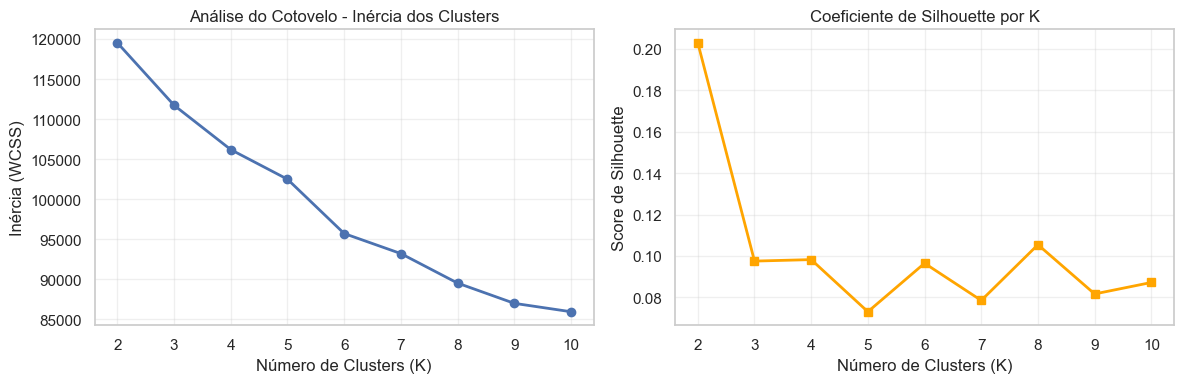

Número ótimo de clusters selecionado: 2 (maior score de silhouette: 0.203)

=== CRIAÇÃO DE NOVAS FEATURES A PARTIR DOS CLUSTERS ===
Dimensionalidade expandida:
Dataset original: (20000, 16)
Dataset enriquecido: (20000, 17)
Nova feature adicionada: distância mínima ao centroide

=== TREINAMENTO E AVALIAÇÃO DOS MODELOS DE MACHINE LEARNING ===

RESULTADOS - MODELOS BASELINE (sem feature de clustering):


,accuracy,precision,recall,f1,auc_roc
SVM_Linear,0.222,0.199,0.222,0.202,0.887
SVM_Polinomial,0.231,0.231,0.231,0.218,0.900
SVM_RBF,0.238,0.224,0.238,0.219,0.903
Random_Forest,0.316,0.306,0.316,0.305,0.914



RESULTADOS - MODELOS ENRIQUECIDOS (com feature de clustering):


,accuracy,precision,recall,f1,auc_roc
SVM_Linear,0.220,0.198,0.220,0.199,0.890
SVM_Polinomial,0.230,0.219,0.230,0.211,0.897
SVM_RBF,0.232,0.211,0.232,0.209,0.899
Random_Forest,0.311,0.299,0.311,0.298,0.911



=== ANÁLISE DO IMPACTO DA FEATURE DE CLUSTERING ===
COMPARAÇÃO DETALHADA - Impacto da Feature de Clustering:


,accuracy_enriquecido,precision_enriquecido,recall_enriquecido,f1_enriquecido,auc_roc_enriquecido,accuracy_baseline,precision_baseline,recall_baseline,f1_baseline,auc_roc_baseline,Ganho_F1
SVM_Linear,0.220,0.198,0.220,0.199,0.890,0.222,0.199,0.222,0.202,0.887,-0.003
SVM_Polinomial,0.230,0.219,0.230,0.211,0.897,0.231,0.231,0.231,0.218,0.900,-0.007
Random_Forest,0.311,0.299,0.311,0.298,0.911,0.316,0.306,0.316,0.305,0.914,-0.007
SVM_RBF,0.232,0.211,0.232,0.209,0.899,0.238,0.224,0.238,0.219,0.903,-0.010


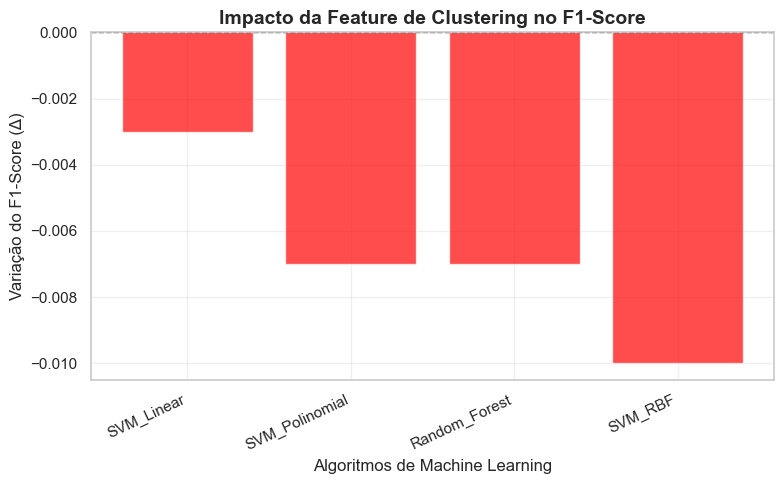

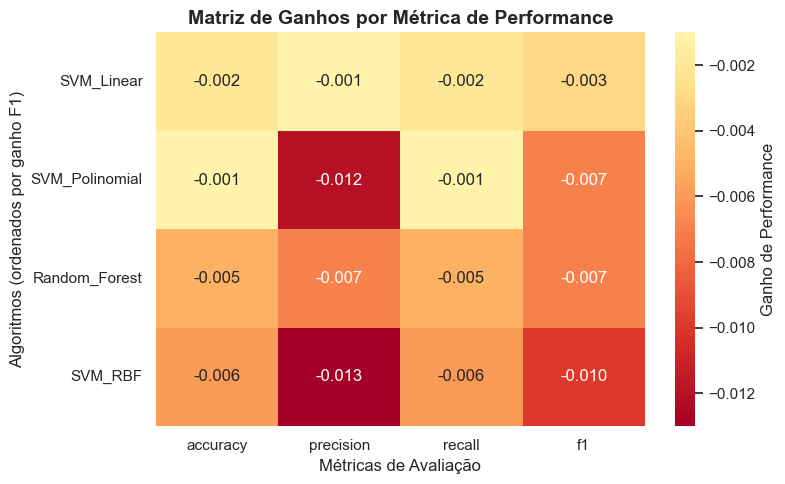

ℹ️  Análise ROC não aplicável - Dataset com múltiplas classes (consulte AUC macro nas tabelas).

=== ANÁLISE DE SENSIBILIDADE - VARIAÇÃO DO NÚMERO DE CLUSTERS ===
RESULTADOS DA ANÁLISE DE SENSIBILIDADE:


,Numero_Clusters,F1_Score_Teste
0,2,0.208818
1,3,0.208812
2,4,0.212020
3,5,0.209785
4,6,0.212539
5,7,0.212067
6,8,0.211579
7,9,0.211502
8,10,0.213921


CONCLUSÃO DA SENSIBILIDADE:
K ótimo para F1-Score: 10
F1-Score máximo alcançado: 0.2139


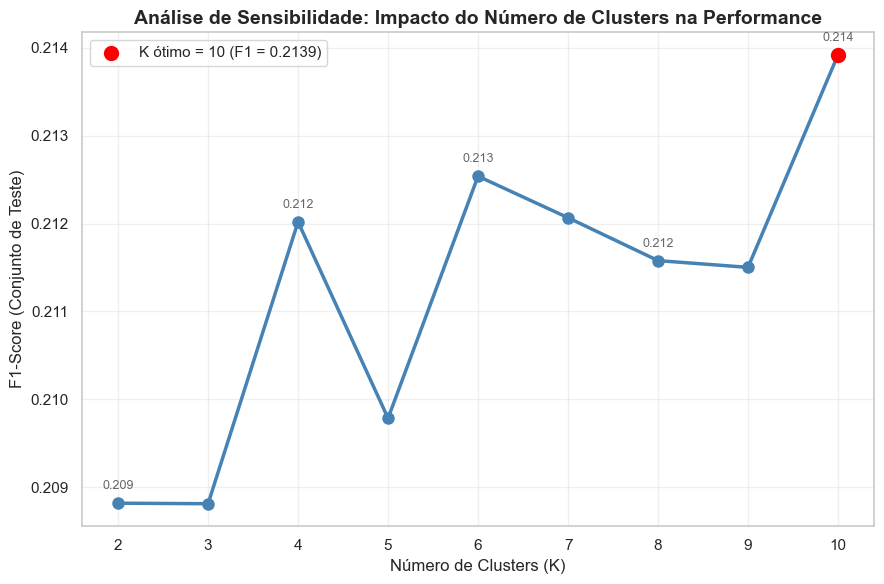


✅ ANÁLISE CONCLUÍDA - Clustering como Feature Engineering implementado com sucesso!


In [1]:
# Configuração inicial e carregamento das bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Importações para processamento de dados e modelagem
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve

# Configurações globais do projeto
ARQUIVO_DADOS = "dataset.csv"
COLUNA_ALVO = "track_genre"
INTERVALO_CLUSTERS = range(2, 11)
SEMENTE_RANDOM = 42
AMOSTRA_AVALIACAO = 10_000
LIMITE_TREINO = 20_000
LIMITE_TESTE = 8_000
USAR_MINIBATCH = False

# Configuração visual dos gráficos
sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
np.random.seed(SEMENTE_RANDOM)

# Carregamento e preparação inicial dos dados
print("=== PREPARAÇÃO E LIMPEZA DOS DADOS ===")
dados_musicais = pd.read_csv(ARQUIVO_DADOS)

# Remoção de colunas identificadoras que não contribuem para predição
colunas_desnecessarias = [col for col in ["Unnamed: 0","track_id","artists","album_name","track_name"] 
                         if col in dados_musicais.columns]
dados_musicais = dados_musicais.drop(columns=colunas_desnecessarias)

# Verificação da presença da variável target
assert COLUNA_ALVO in dados_musicais.columns, f"Coluna alvo '{COLUNA_ALVO}' não encontrada no dataset."

# Separação das features e target
target_values = dados_musicais[COLUNA_ALVO]
features_matrix = dados_musicais.drop(columns=[COLUNA_ALVO])

# Codificação da variável target se necessário
if target_values.dtype == "object":
    target_values = LabelEncoder().fit_transform(target_values)

# Identificação de tipos de variáveis
colunas_numericas = features_matrix.select_dtypes(include=[np.number]).columns.tolist()
colunas_categoricas = [col for col in features_matrix.columns if col not in colunas_numericas]

print(f"Dimensões do dataset: {dados_musicais.shape}")
print(f"Variáveis numéricas: {len(colunas_numericas)} | Variáveis categóricas: {len(colunas_categoricas)}")

# Divisão inicial treino/teste
X_treino_bruto, X_teste_bruto, y_treino_completo, y_teste_completo = train_test_split(
    features_matrix, target_values, test_size=0.25, random_state=SEMENTE_RANDOM, stratify=target_values
)

# Função para amostragem estratificada otimizada
def amostragem_estratificada_balanceada(matriz_X, vetor_y, tamanho_max, seed_valor):
    """
    Realiza amostragem estratificada mantendo proporcionalidade das classes
    """
    if len(vetor_y) <= tamanho_max:
        return matriz_X, vetor_y
    
    estratificador = StratifiedShuffleSplit(n_splits=1, train_size=tamanho_max, random_state=seed_valor)
    indices_selecionados, _ = next(estratificador.split(np.zeros(len(vetor_y)), vetor_y))
    return matriz_X.iloc[indices_selecionados], vetor_y[indices_selecionados]

# Aplicação da amostragem estratificada
X_treino_reduzido, y_treino_final = amostragem_estratificada_balanceada(
    X_treino_bruto, y_treino_completo, LIMITE_TREINO, SEMENTE_RANDOM
)
X_teste_reduzido, y_teste_final = amostragem_estratificada_balanceada(
    X_teste_bruto, y_teste_completo, LIMITE_TESTE, SEMENTE_RANDOM
)

print(f"Conjuntos balanceados → Treino: {X_treino_reduzido.shape[0]} | Teste: {X_teste_reduzido.shape[0]}")

# Configuração do preprocessamento de dados
try:
    codificador_categorico = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    codificador_categorico = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Mapeamento de índices das colunas por tipo
indices_numericos = [features_matrix.columns.get_loc(col) for col in colunas_numericas]
indices_categoricos = [features_matrix.columns.get_loc(col) for col in colunas_categoricas]

# Pipeline de preprocessamento
preprocessador = ColumnTransformer(
    transformers=[
        ("numericas", StandardScaler(), indices_numericos),
        ("categoricas", codificador_categorico, indices_categoricos),
    ],
    remainder="drop", verbose_feature_names_out=False
)

# Aplicação da transformação
X_treino_processado = preprocessador.fit_transform(X_treino_reduzido)
X_teste_processado = preprocessador.transform(X_teste_reduzido)
print(f"Dados processados → Treino: {X_treino_processado.shape} | Teste: {X_teste_processado.shape}")

# === ANÁLISE DE CLUSTERIZAÇÃO K-MEANS ===
print("\n=== DETERMINAÇÃO DO NÚMERO ÓTIMO DE CLUSTERS ===")

# Criação de amostra para otimização de K
tamanho_amostra = min(AMOSTRA_AVALIACAO, X_treino_processado.shape[0])
indices_amostra = np.random.choice(X_treino_processado.shape[0], size=tamanho_amostra, replace=False)
dados_amostra_clusters = X_treino_processado[indices_amostra]

# Avaliação de diferentes valores de K
valores_inercia, coeficientes_silhouette = [], []

for numero_clusters in INTERVALO_CLUSTERS:
    # Aplicação do MiniBatchKMeans para eficiência computacional
    modelo_cluster = MiniBatchKMeans(
        n_clusters=numero_clusters, 
        batch_size=1024, 
        n_init=10, 
        random_state=SEMENTE_RANDOM
    )
    rotulos_clusters = modelo_cluster.fit_predict(dados_amostra_clusters)
    
    # Cálculo das métricas de avaliação
    valores_inercia.append(modelo_cluster.inertia_)
    coeficientes_silhouette.append(silhouette_score(dados_amostra_clusters, rotulos_clusters))

# Visualização das métricas de avaliação
figura, eixos = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico do método do cotovelo
eixos[0].plot(list(INTERVALO_CLUSTERS), valores_inercia, marker="o", linewidth=2, markersize=6)
eixos[0].set_title("Análise do Cotovelo - Inércia dos Clusters")
eixos[0].set_xlabel("Número de Clusters (K)")
eixos[0].set_ylabel("Inércia (WCSS)")
eixos[0].grid(True, alpha=0.3)

# Gráfico do coeficiente de silhouette
eixos[1].plot(list(INTERVALO_CLUSTERS), coeficientes_silhouette, marker="s", linewidth=2, markersize=6, color='orange')
eixos[1].set_title("Coeficiente de Silhouette por K")
eixos[1].set_xlabel("Número de Clusters (K)")
eixos[1].set_ylabel("Score de Silhouette")
eixos[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Seleção do K ótimo baseado no maior coeficiente de silhouette
k_otimo = list(INTERVALO_CLUSTERS)[int(np.argmax(coeficientes_silhouette))]
print(f"Número ótimo de clusters selecionado: {k_otimo} (maior score de silhouette: {max(coeficientes_silhouette):.3f})")

# Treinamento do modelo de clustering final
if USAR_MINIBATCH:
    modelo_clustering_final = MiniBatchKMeans(
        n_clusters=k_otimo, 
        batch_size=2048, 
        n_init=10, 
        random_state=SEMENTE_RANDOM
    ).fit(X_treino_processado)
else:
    modelo_clustering_final = KMeans(
        n_clusters=k_otimo, 
        n_init=10, 
        random_state=SEMENTE_RANDOM
    ).fit(X_treino_processado)

# === ENGENHARIA DE FEATURES BASEADA EM CLUSTERING ===
print("\n=== CRIAÇÃO DE NOVAS FEATURES A PARTIR DOS CLUSTERS ===")

# Cálculo das distâncias aos centroides para conjunto de treino e teste
distancias_treino = modelo_clustering_final.transform(X_treino_processado)
distancias_teste = modelo_clustering_final.transform(X_teste_processado)

# Criação da feature de proximidade: distância mínima ao centroide mais próximo
feature_proximidade_treino = distancias_treino.min(axis=1, keepdims=True)
feature_proximidade_teste = distancias_teste.min(axis=1, keepdims=True)

# Concatenação das features originais com a nova feature de clustering
X_treino_enriquecido = np.hstack([X_treino_processado, feature_proximidade_treino])
X_teste_enriquecido = np.hstack([X_teste_processado, feature_proximidade_teste])

print(f"Dimensionalidade expandida:")
print(f"Dataset original: {X_treino_processado.shape}")
print(f"Dataset enriquecido: {X_treino_enriquecido.shape}")
print(f"Nova feature adicionada: distância mínima ao centroide")

# === MODELAGEM E COMPARAÇÃO DE PERFORMANCE ===
print("\n=== TREINAMENTO E AVALIAÇÃO DOS MODELOS DE MACHINE LEARNING ===")

# Definição do portfólio de algoritmos para comparação
portifolio_algoritmos = {
    "SVM_Linear": SVC(kernel="linear", C=1.0, probability=True, random_state=SEMENTE_RANDOM),
    "SVM_Polinomial": SVC(kernel="poly", degree=2, C=1.0, gamma="scale", probability=True, random_state=SEMENTE_RANDOM),
    "SVM_RBF": SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=SEMENTE_RANDOM),
    "Random_Forest": RandomForestClassifier(n_estimators=300, random_state=SEMENTE_RANDOM, n_jobs=-1),
}

def avaliar_performance_modelo(classificador, X_trein, y_trein, X_valid, y_valid):
    """
    Função para avaliação completa de performance de um modelo
    """
    # Treinamento do modelo
    classificador.fit(X_trein, y_trein)
    
    # Predições
    predicoes = classificador.predict(X_valid)
    probabilidades = classificador.predict_proba(X_valid) if hasattr(classificador, "predict_proba") else None
    
    # Cálculo de métricas de performance
    acuracia = accuracy_score(y_valid, predicoes)
    precisao, recall, f1_score, _ = precision_recall_fscore_support(y_valid, predicoes, average="weighted", zero_division=0)
    
    metricas_resultado = {
        "accuracy": acuracia, 
        "precision": precisao, 
        "recall": recall, 
        "f1": f1_score
    }
    
    # Cálculo do AUC-ROC quando aplicável
    if probabilidades is not None:
        if len(np.unique(y_valid)) > 2:
            # Problema multiclasse
            metricas_resultado["auc_roc"] = roc_auc_score(
                pd.get_dummies(y_valid), probabilidades, 
                average="macro", multi_class="ovr"
            )
        else:
            # Problema binário
            metricas_resultado["auc_roc"] = roc_auc_score(y_valid, probabilidades[:, -1])
    
    return metricas_resultado, probabilidades

# Avaliação comparativa: com e sem feature de clustering
resultados_baseline, resultados_enriquecido, probabilidades_enriquecidas = {}, {}, {}

for nome_algoritmo, classificador in portifolio_algoritmos.items():
    # Avaliação sem feature de clustering (baseline)
    resultados_baseline[nome_algoritmo], _ = avaliar_performance_modelo(
        classificador, X_treino_processado, y_treino_final, X_teste_processado, y_teste_final
    )
    
    # Avaliação com feature de clustering (enriquecido)
    resultados_enriquecido[nome_algoritmo], probs_resultado = avaliar_performance_modelo(
        classificador, X_treino_enriquecido, y_treino_final, X_teste_enriquecido, y_teste_final
    )
    probabilidades_enriquecidas[nome_algoritmo] = probs_resultado

# Conversão para DataFrames para visualização
tabela_baseline = pd.DataFrame(resultados_baseline).T.round(3)
tabela_enriquecida = pd.DataFrame(resultados_enriquecido).T.round(3)

print("\nRESULTADOS - MODELOS BASELINE (sem feature de clustering):")
display(tabela_baseline)

print("\nRESULTADOS - MODELOS ENRIQUECIDOS (com feature de clustering):")
display(tabela_enriquecida)

# === ANÁLISE COMPARATIVA DE IMPACTO ===
print("\n=== ANÁLISE DO IMPACTO DA FEATURE DE CLUSTERING ===")

# Cálculo das diferenças de performance entre modelos enriquecidos e baseline
tabela_comparativa = tabela_enriquecida.add_suffix("_enriquecido").join(tabela_baseline.add_suffix("_baseline"))
tabela_comparativa["Ganho_F1"] = tabela_comparativa["f1_enriquecido"] - tabela_comparativa["f1_baseline"]

# Ordenação por ganho em F1-Score
tabela_ordenada = tabela_comparativa.sort_values("Ganho_F1", ascending=False)

print("COMPARAÇÃO DETALHADA - Impacto da Feature de Clustering:")
display(tabela_ordenada.round(3))

# Visualização 1: Gráfico de barras do ganho em F1-Score
plt.figure(figsize=(8, 5))
cores_barras = ['green' if x > 0 else 'red' for x in tabela_ordenada["Ganho_F1"]]
plt.bar(tabela_ordenada.index, tabela_ordenada["Ganho_F1"], color=cores_barras, alpha=0.7)
plt.axhline(0, color="black", linewidth=1, linestyle="--", alpha=0.8)
plt.title("Impacto da Feature de Clustering no F1-Score", fontsize=14, fontweight='bold')
plt.ylabel("Variação do F1-Score (Δ)", fontsize=12)
plt.xlabel("Algoritmos de Machine Learning", fontsize=12)
plt.xticks(rotation=25, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualização 2: Heatmap dos ganhos por métrica
metricas_interesse = ["accuracy", "precision", "recall", "f1"]
matriz_ganhos = (tabela_enriquecida[metricas_interesse] - tabela_baseline[metricas_interesse]).loc[tabela_ordenada.index]

plt.figure(figsize=(8, 5))
sns.heatmap(matriz_ganhos, annot=True, fmt=".3f", cmap="RdYlGn", center=0, 
            cbar_kws={'label': 'Ganho de Performance'})
plt.title("Matriz de Ganhos por Métrica de Performance", fontsize=14, fontweight='bold')
plt.ylabel("Algoritmos (ordenados por ganho F1)", fontsize=12)
plt.xlabel("Métricas de Avaliação", fontsize=12)
plt.tight_layout()
plt.show()

# Visualização 3: Curvas ROC (apenas para problemas binários)
if len(np.unique(y_teste_final)) == 2:
    plt.figure(figsize=(8, 6))
    cores_roc = ['blue', 'orange', 'green', 'red']
    
    for i, (nome_modelo, probabilidades) in enumerate(probabilidades_enriquecidas.items()):
        if probabilidades is None: 
            continue
        
        taxa_falso_positivo, taxa_verdadeiro_positivo, _ = roc_curve(y_teste_final, probabilidades[:, -1])
        auc_valor = roc_auc_score(y_teste_final, probabilidades[:, -1])
        
        plt.plot(taxa_falso_positivo, taxa_verdadeiro_positivo, 
                color=cores_roc[i % len(cores_roc)], linewidth=2,
                label=f'{nome_modelo} (AUC = {auc_valor:.3f})')
    
    # Linha de referência (classificador aleatório)
    plt.plot([0, 1], [0, 1], "--", color="gray", linewidth=1, alpha=0.8, label="Classificador Aleatório")
    
    plt.title("Curvas ROC - Modelos com Feature de Clustering", fontsize=14, fontweight='bold')
    plt.xlabel("Taxa de Falsos Positivos (FPR)", fontsize=12)
    plt.ylabel("Taxa de Verdadeiros Positivos (TPR)", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("ℹ️  Análise ROC não aplicável - Dataset com múltiplas classes (consulte AUC macro nas tabelas).")

# === ESTUDO DE SENSIBILIDADE: INFLUÊNCIA DO NÚMERO DE CLUSTERS ===
print("\n=== ANÁLISE DE SENSIBILIDADE - VARIAÇÃO DO NÚMERO DE CLUSTERS ===")

# Avaliação sistemática do impacto do número de clusters na performance
resultados_sensibilidade = []

for num_clusters_teste in INTERVALO_CLUSTERS:
    # Criação de novo modelo de clustering com K específico
    modelo_teste = MiniBatchKMeans(
        n_clusters=num_clusters_teste, 
        batch_size=2048, 
        n_init=10, 
        random_state=SEMENTE_RANDOM
    ).fit(X_treino_processado)
    
    # Geração de features de clustering para este K
    distancias_treino_teste = modelo_teste.transform(X_treino_processado)
    distancias_teste_teste = modelo_teste.transform(X_teste_processado)
    
    feature_clustering_treino = distancias_treino_teste.min(axis=1, keepdims=True)
    feature_clustering_teste = distancias_teste_teste.min(axis=1, keepdims=True)
    
    # Construção dos datasets enriquecidos para este K
    X_treino_k = np.hstack([X_treino_processado, feature_clustering_treino])
    X_teste_k = np.hstack([X_teste_processado, feature_clustering_teste])
    
    # Avaliação com SVM RBF (modelo de referência)
    classificador_referencia = SVC(
        kernel="rbf", 
        C=1.0, 
        gamma="scale", 
        probability=True, 
        random_state=SEMENTE_RANDOM
    )
    
    classificador_referencia.fit(X_treino_k, y_treino_final)
    predicoes_k = classificador_referencia.predict(X_teste_k)
    f1_score_k = precision_recall_fscore_support(y_teste_final, predicoes_k, average="weighted", zero_division=0)[2]
    
    resultados_sensibilidade.append((num_clusters_teste, f1_score_k))

# Conversão para DataFrame para análise
tabela_sensibilidade = pd.DataFrame(resultados_sensibilidade, columns=["Numero_Clusters", "F1_Score_Teste"])

print("RESULTADOS DA ANÁLISE DE SENSIBILIDADE:")
display(tabela_sensibilidade)

# Identificação do K que maximiza o F1-Score
k_otimo_f1 = tabela_sensibilidade.loc[tabela_sensibilidade["F1_Score_Teste"].idxmax(), "Numero_Clusters"]
f1_maximo = tabela_sensibilidade["F1_Score_Teste"].max()

print(f"CONCLUSÃO DA SENSIBILIDADE:")
print(f"K ótimo para F1-Score: {k_otimo_f1}")
print(f"F1-Score máximo alcançado: {f1_maximo:.4f}")

# Visualização da curva de sensibilidade
plt.figure(figsize=(9, 6))
plt.plot(tabela_sensibilidade["Numero_Clusters"], tabela_sensibilidade["F1_Score_Teste"], 
         marker="o", linewidth=2.5, markersize=8, color='steelblue')

# Destaque do ponto ótimo
plt.scatter(k_otimo_f1, f1_maximo, color='red', s=100, zorder=5, 
           label=f'K ótimo = {k_otimo_f1} (F1 = {f1_maximo:.4f})')

plt.title("Análise de Sensibilidade: Impacto do Número de Clusters na Performance", 
          fontsize=14, fontweight='bold')
plt.xlabel("Número de Clusters (K)", fontsize=12)
plt.ylabel("F1-Score (Conjunto de Teste)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(list(INTERVALO_CLUSTERS))

# Adição de anotações para melhor interpretação
for i, (k, f1) in enumerate(resultados_sensibilidade):
    if i % 2 == 0:  # Anotação a cada 2 pontos para evitar poluição visual
        plt.annotate(f'{f1:.3f}', (k, f1), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9, alpha=0.7)

plt.tight_layout()
plt.show()

print("\n✅ ANÁLISE CONCLUÍDA - Clustering como Feature Engineering implementado com sucesso!")